In [38]:
import re
import csv
import unicodedata
import warnings
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

## Clasificadores
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB

warnings.filterwarnings('ignore')

# Filenames
file_name="./csv/0_500_union_salida_clasificada_python.csv"
stop_file="custom_stopwords.txt"    # Nombre del archivo de stopwords.


# Regex para tokenizar correctamente.
regex_str = [
    r'(?:[\w_]+)',                                        # Otras palabras
    r'(?:\S)'                                             # Cualquier otra cosa
]

# Se arman objetos para regular expresions.
tokens_re   = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)

# Se carga archivos de STOPWORDS
with open(stop_file, newline='') as file:
    stopwords = file.read().splitlines()

X = []
xWC_con = []
xWC_sin = []
clase = []
tipo = []
    
# Se abre archivo con tweets y se lo recorre    
with open(file_name, newline='') as csvfile:

    reader = csv.reader(csvfile, delimiter=';', quotechar='\"')
    header = next(reader)
    
    for row in reader:

        clase.append(row[2].lower())
        tipo.append(row[3].lower())
        
        tweet = row[4].lower()                    # Se normaliza texto, todo a minusculas.
        tweet = re.sub(r'@[a-z0-9_]+', '', tweet) # Se quitan menciones. @xxxxxxxx
        tweet = re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', '', tweet)
        tweet = tweet.translate(str.maketrans('','', '.~¡!-_—#$%¿?:+-/°);(/",*“”‘’'))
        
        # Manejo de emoticones.
        emoticones = [
                      ['😆',' risa'],['😂','risa'],['😱',' asombro'],['🥳',' felicidad'],['💙',' amor'],['😍',' amor'],
                      ['😀',' sonreir'],['👍',' ok'],['🤔',' dudar'],['🎊',' alegria'],['🙏',' ojala'],['💪🏻',' fuerza'],
                      ['😡',' enojo'],['😛',' broma'],['😮',' asombro'],['🤮',' desagradable'],['👏🏻',' aplauso'],
                      ['😏',' canchero'],['😩',' decepcion'],['😳',' verguenza'],['😊',' contento'],['😥',' triste'],
                      ['😤',' furioso'],['🖕',' enojo'],['👏',' aplauso'],['💪',' fuerza'],['🤦‍','increible'],
                      ['🙄','duda']
                     ]
        for emoji in emoticones:
            tweet = tweet.replace(emoji[0], emoji[1])

        # Manejo de acentos.
        dict_acentos = [['á','a'],['é','e'],['í','i'],['ó','o'],['ú','u']]
        for acento in dict_acentos:
            tweet = tweet.replace(acento[0], acento[1])
            
        # Remueve letras repetidas y deja una sola.
        for letra in ['a','e','i','o','u','s','c']:
            pattern = letra + '{2,}'
            tweet = re.sub(pattern, letra, tweet)
        
        tweet = tweet.translate(str.maketrans('','', '🥝🐧🐳🖐🛫😑✈🇦🇷🇵🇾👇🙃▶💻►→⬇️😒🔫🔝🔥💀🚫😞♂❤❤❤😎👊🤞🏻'))
        tweet = re.sub(r'\d+', '', tweet)         # Se quitan numeros.
        tweet = tweet.strip()
    
        # Tokenizado
        tokens = tokens_re.findall(tweet)
        
        xWC_con.append(s.join(tokens))
        
        # Remocion de stopwords
        tokens = [token for token in tokens if token not in stopwords]
        
        #Para resumen        
        X.append(tokens)
        
        s = ' '
        xWC_sin.append(s.join(tokens))



# Medidas de resumen
data = pd.DataFrame(X)

# # Using DataFrame.insert() to add a column 
data.insert(0, "Clase", clase, True)
data.insert(1, "Tipo", tipo, True)

data.head()

,Clase,Tipo,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,neutro,arsa,nunca,fue,siempre,estuvo,ar,cargo,son,quienes,...,None,None,None,None,None,None,None,None,None,None
1,positivo,arsa,esto,siempre,pienso,deberia,volver,aerolineas,cargo,None,...,None,None,None,None,None,None,None,None,None,None
2,neutro,arsa,transporta,miami,nueva,york,asi,tambien,madrid,roma,...,None,None,None,None,None,None,None,None,None,None
3,neutro,arsa,completo,semana,pasada,envio,eu,cargamento,arandanos,producidos,...,total,tn,None,None,None,None,None,None,None,None
4,neutro,arsa,toneladas,arandanos,semana,van,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [30]:
from collections import Counter
Counter(data["Tipo"])

arsa  = data["Tipo"] == "arsa"
vw    = data["Tipo"] == "vw"
fiber = data["Tipo"] == "fibertel"
apple = data["Tipo"] == "apple"

subarsa  = data[arsa]
subvw    = data[vw]
subfiber = data[fiber]
subapple = data[apple]

resumenArsa  = Counter(subarsa["Clase"])
resumenVw    = Counter(subvw["Clase"])
resumenFiber = Counter(subfiber["Clase"])
resumenApple = Counter(subapple["Clase"])

print('\tNeg \tNeu \tPos')
print('ARSA\t', resumenArsa['negativo'], '\t', resumenArsa['neutro'], '\t', resumenArsa['positivo'])
print('VW\t', resumenVw['negativo'], '\t', resumenVw['neutro'], '\t', resumenVw['positivo'])
print('FIBERTEL', resumenFiber['negativo'], '\t', resumenFiber['neutro'], '\t', resumenFiber['positivo'])
print('APPLE\t', resumenApple['negativo'], '\t', resumenApple['neutro'], '\t', resumenApple['positivo'])

	Neg 	Neu 	Pos
ARSA	 70 	 32 	 57
VW	 30 	 24 	 23
FIBERTEL 73 	 28 	 8
APPLE	 83 	 37 	 35


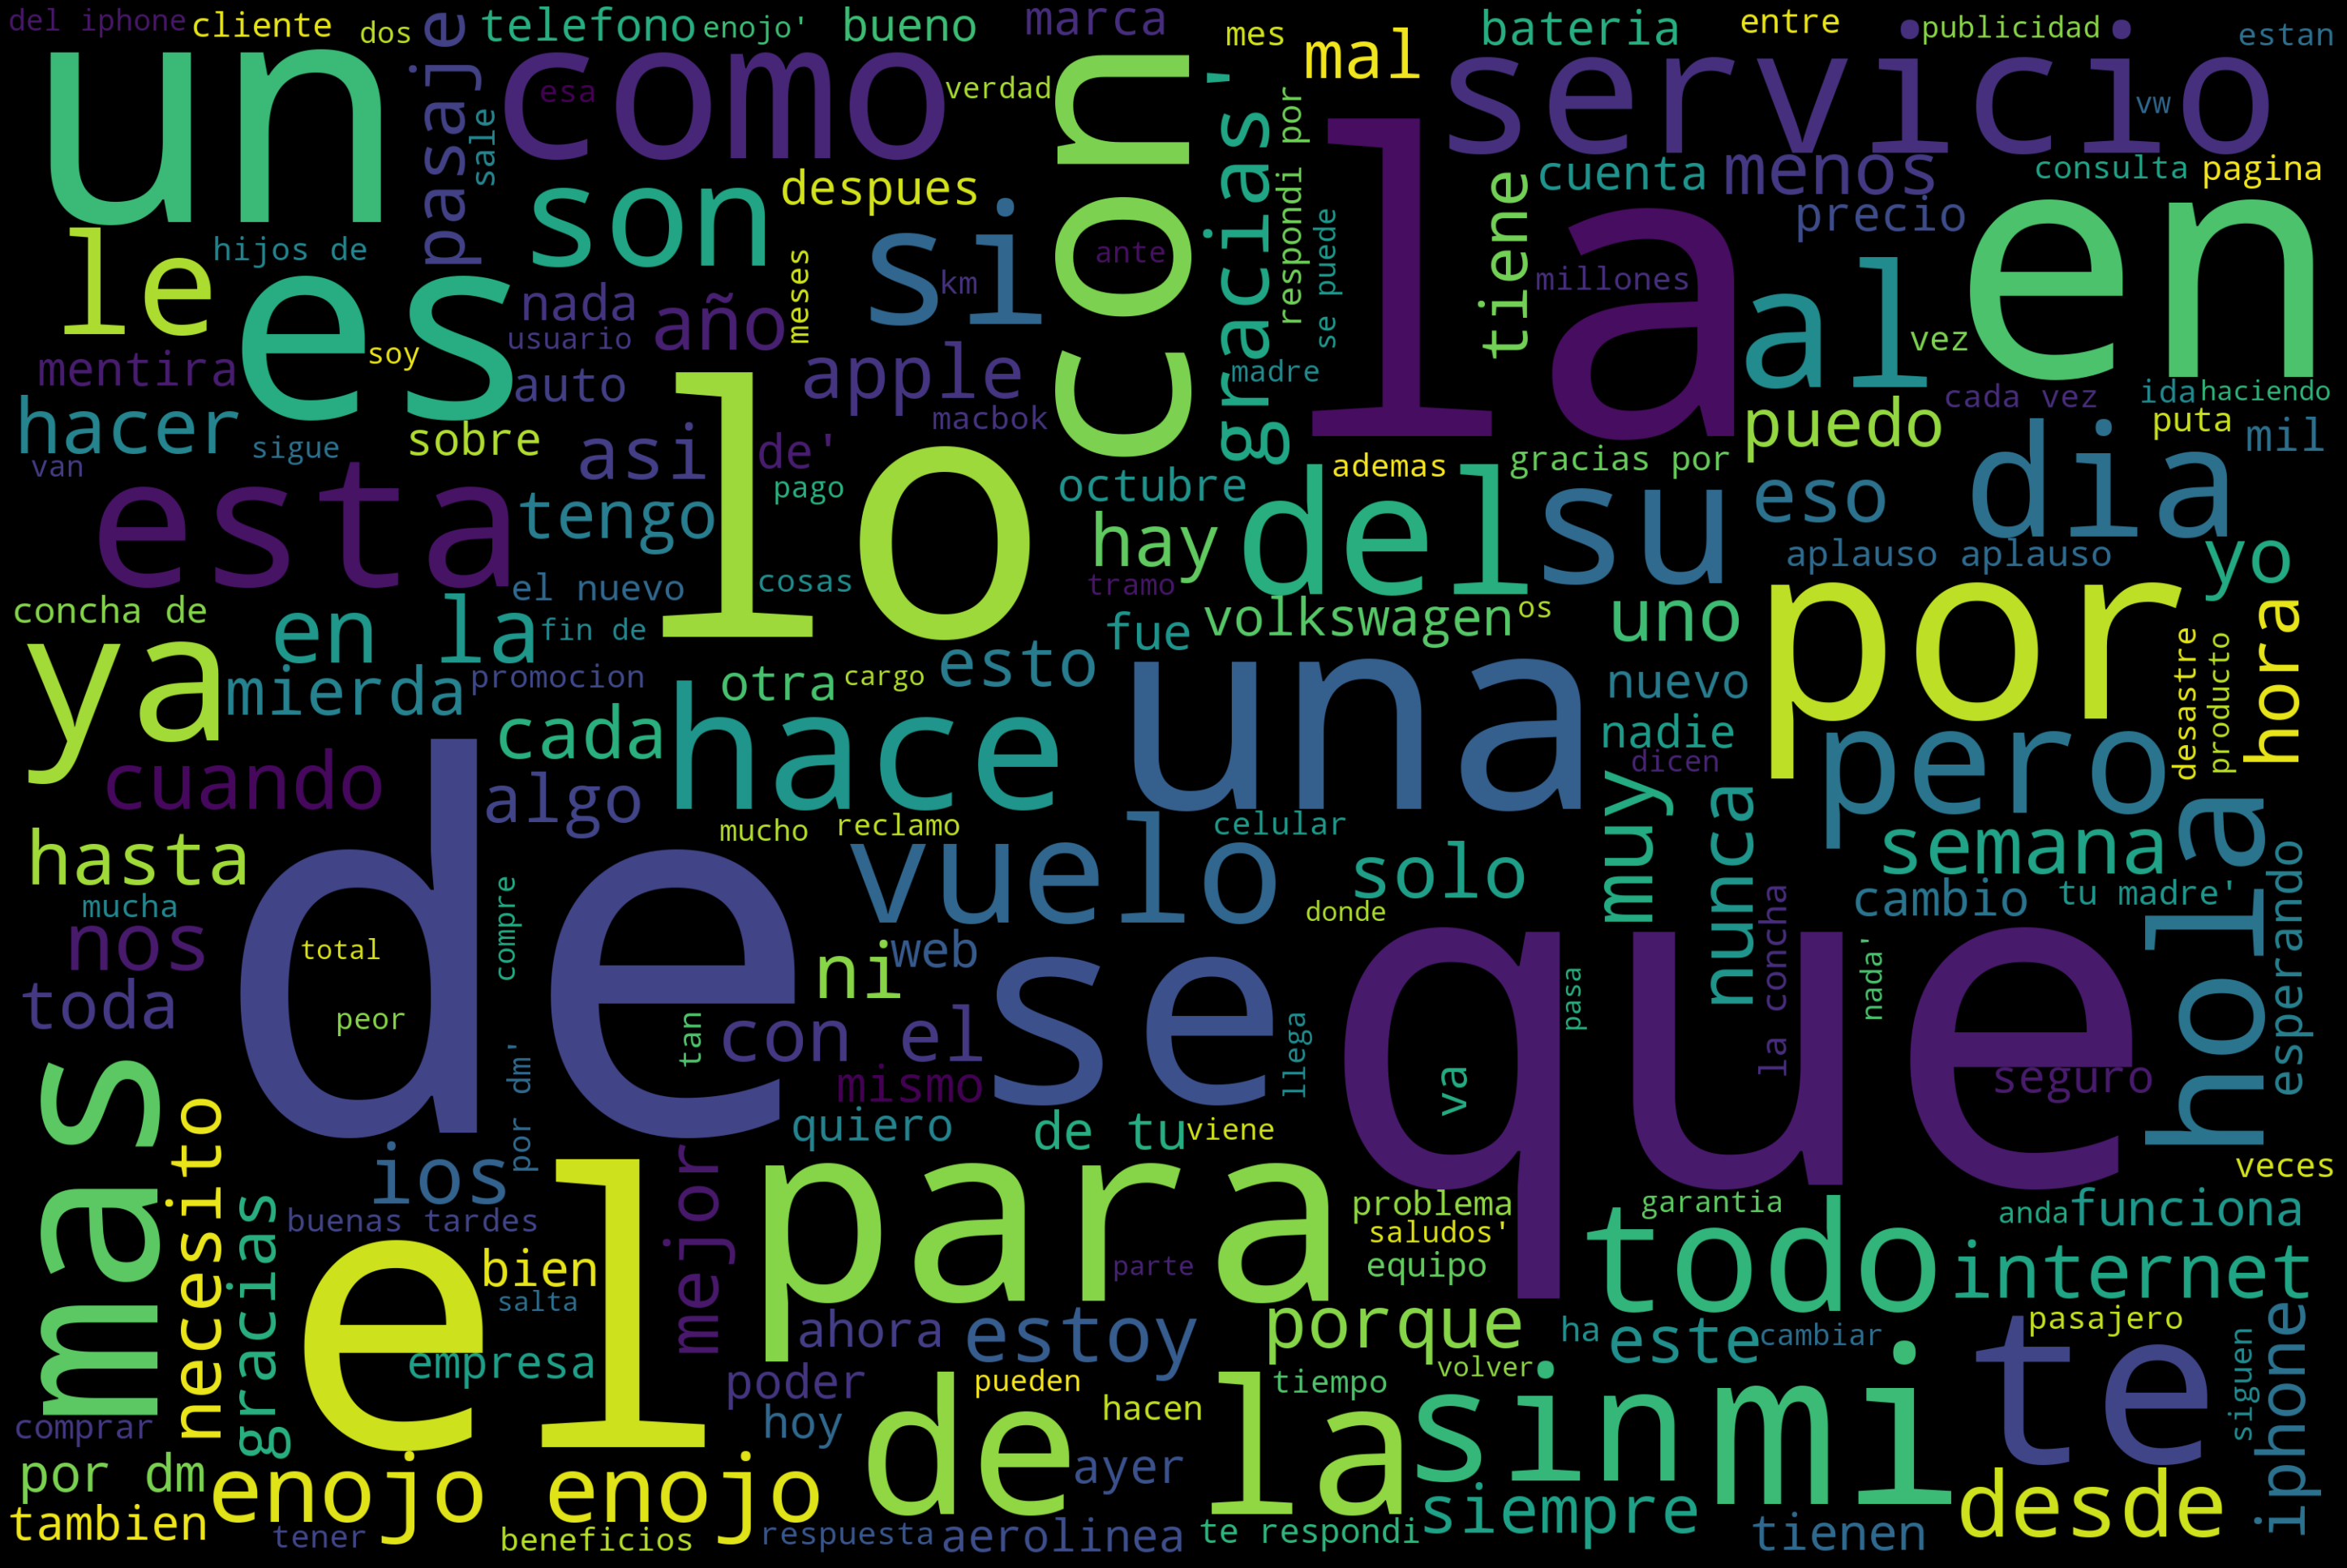

In [31]:
#text = data.Tweet.values
text = xWC_con

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

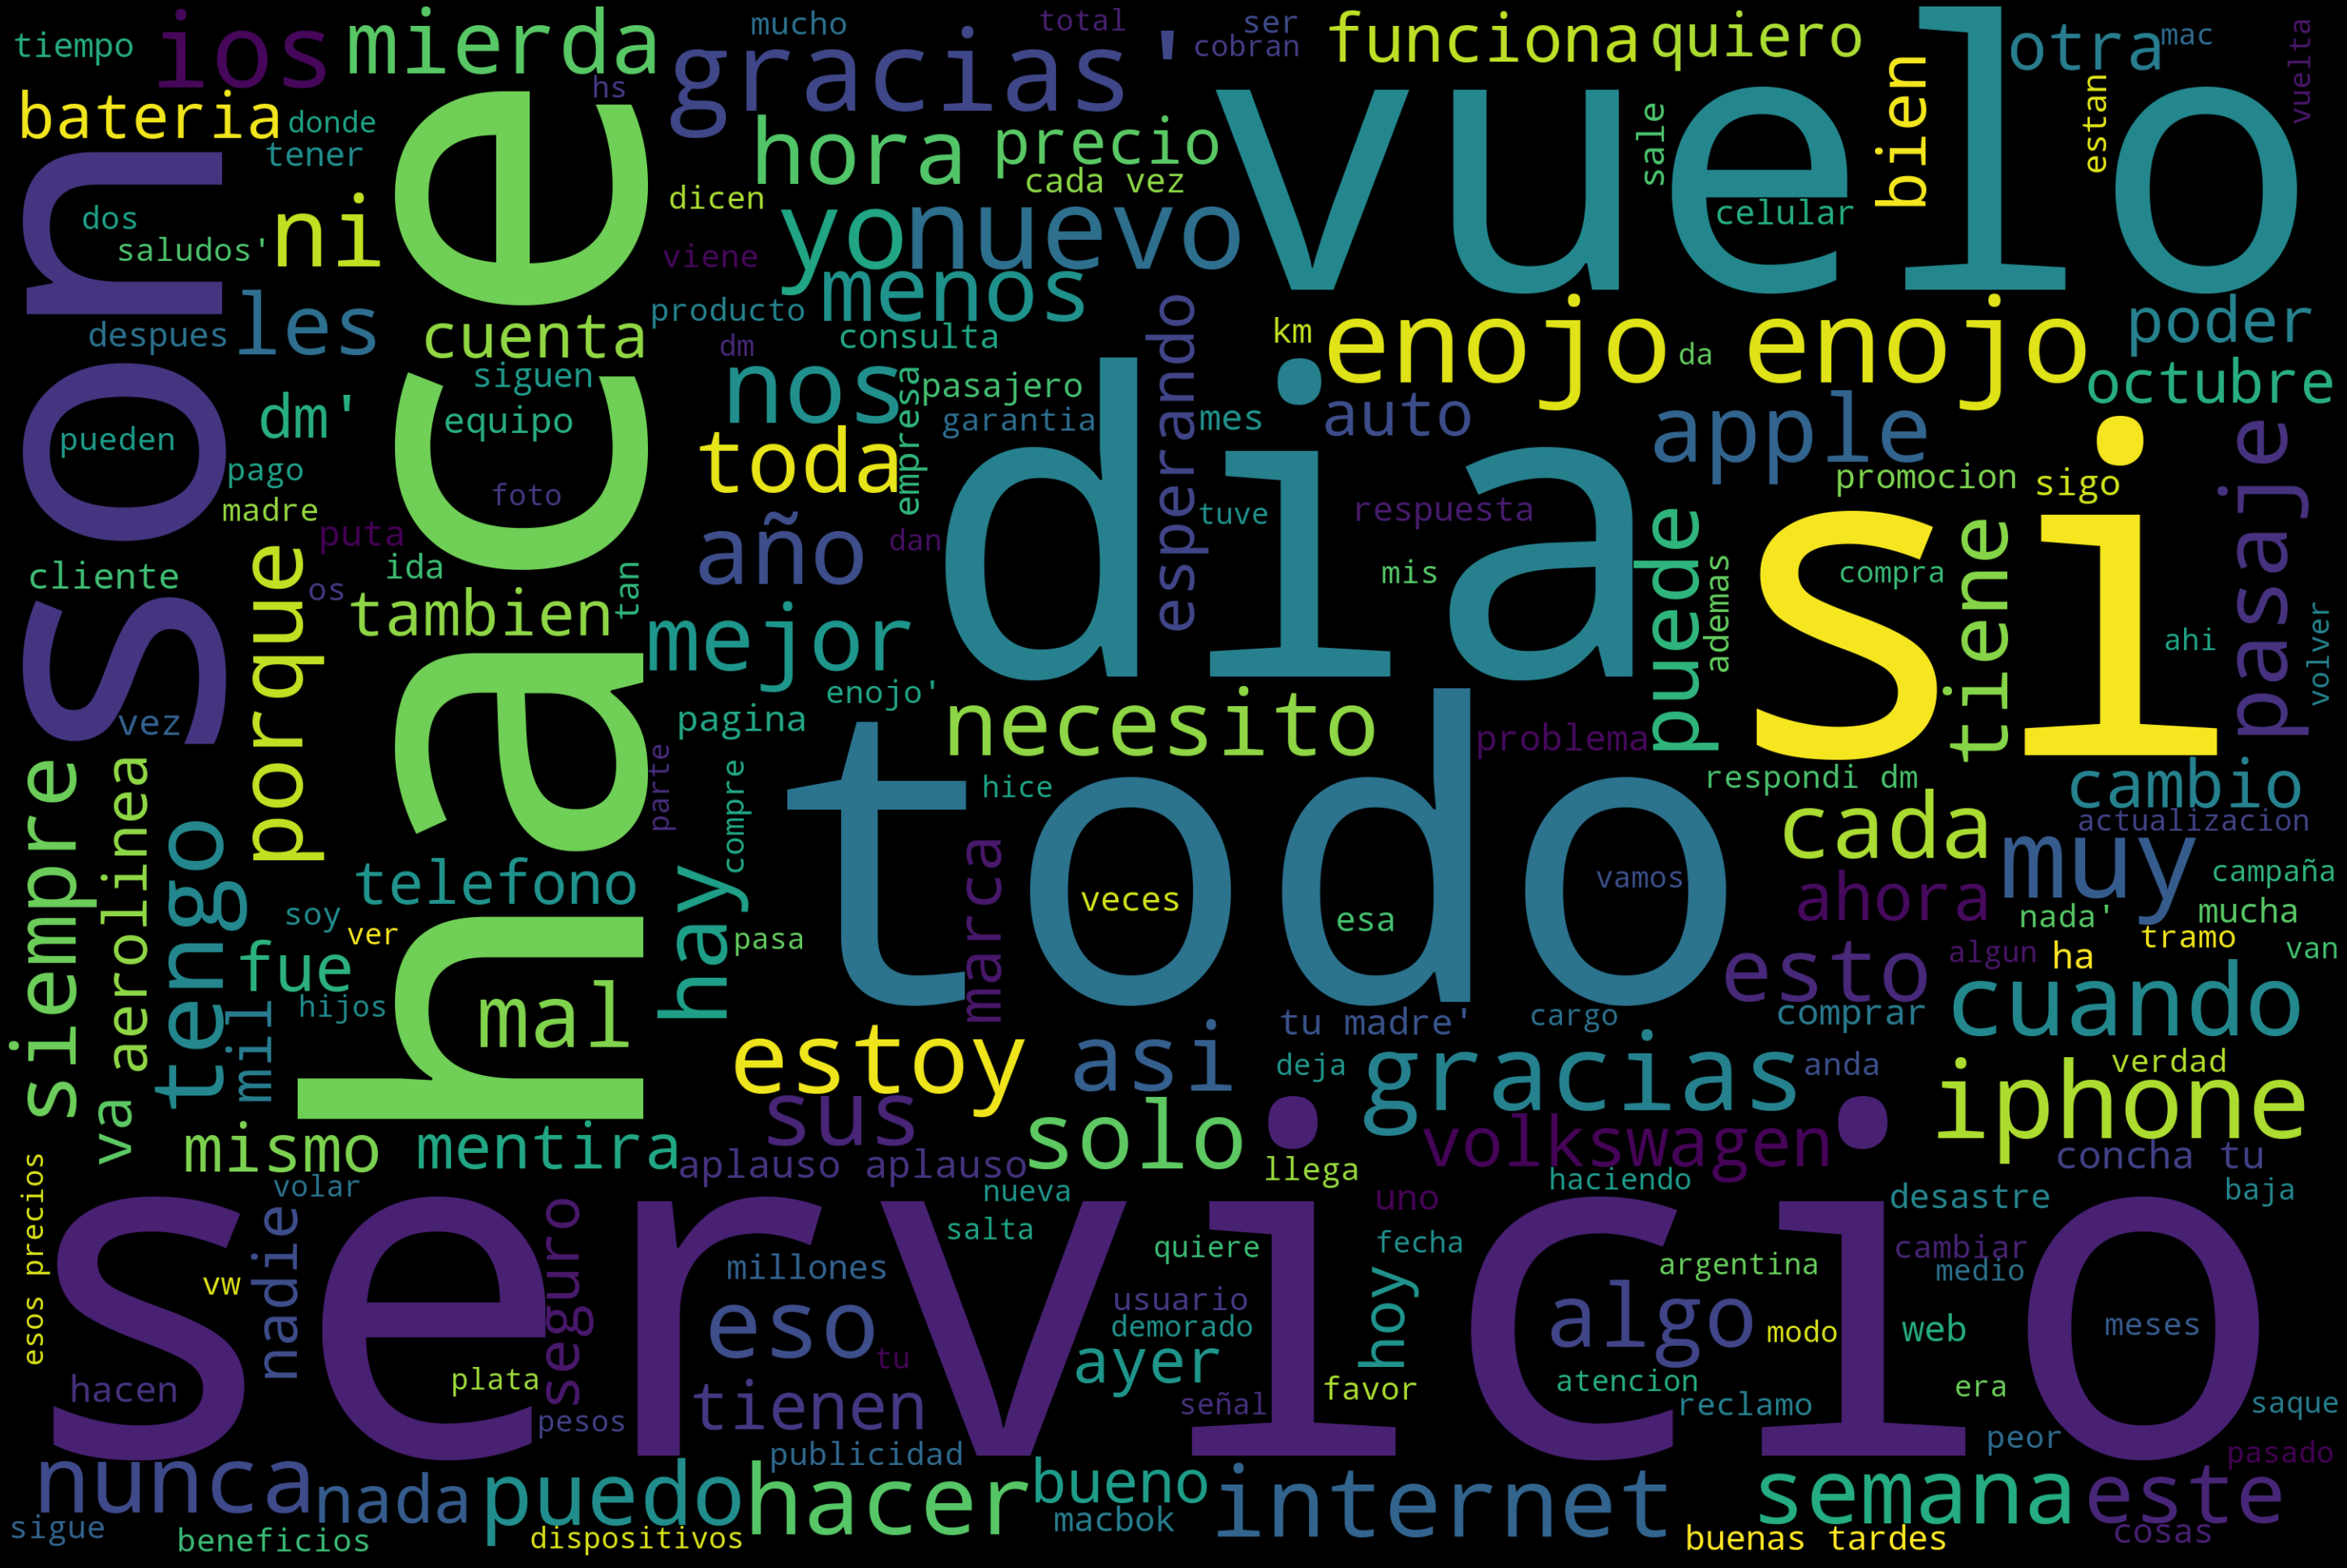

In [39]:
#text = data.Tweet.values
text = xWC_sin

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [112]:
#xWC_sin

vectorizer = CountVectorizer()
cuenta = vectorizer.fit_transform(xWC_sin)

words = vectorizer.get_feature_names()
print(len(words))

sumas = cuenta.sum(axis=0)
print(sumas.shape)
sumas_a = sumas.flatten()
for i in sumas_a[0,:]:
    
# for i in range(len(words)):
#     print(words[i])

2328
(1, 2328)
[[1 1 1 ... 1 1 2]]
